In [1]:
import os, sys, glob
import json, csv, re, datetime
import pickle
import collections

from matplotlib import pyplot as plt
from tqdm import tqdm

from dir_build_dataset_tweets import read_vids

In [2]:
# filter criterion: video must have last-day viewcount of 270+
# vidsfile    = "/home/users/u6314203/pyProject/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
# tweets_dataset_base = "/localdata/u6314203/dataset_tweets"
vidsfile    = "C:/Users/u6314203/pyProjects/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
tweets_dataset_base = "G:/MLCV dataset/engagement'16/tweets_dataset_400days"
engage_dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos"

categories_eligible = ["autos", "comedy","education","entertainment", \
                       "film","gaming","howto","music",\
                       "news","people","science","sports",\
                       "travel"]

In [3]:
engage_vids = read_vids(vidsfile)
tweets_vids = collections.defaultdict(list)

print("Num. videos in tweets dataset that exist in engage16")
for category in categories_eligible[:]:
    tweetsFile = os.path.join(tweets_dataset_base, "{}.json".format(category))
    with open(tweetsFile, "r") as f:
        tweetsData = json.load(f)
    exists, total  = 0, len(engage_vids[category])
    for vid, _ in tweetsData.items():
        if vid in engage_vids[category]:
            tweets_vids[category].append(vid)
            exists += 1
            
    print("{}: {}/{}".format(category, exists, total))

Num. videos in tweets dataset that exist in engage16
autos: 25597/25712
comedy: 31678/31741
education: 41005/41191
entertainment: 179517/180128
film: 42954/43101
gaming: 221470/222236
howto: 60796/61027
music: 117764/118094
news: 38082/38249
people: 221975/222658
science: 32148/32278
sports: 39537/39649
travel: 13043/13112


In [4]:
def engage_days(test_category, eval_days = [90, 135, 180, 225, 270]):
    # read days info in engage16
    with open(os.path.join(engage_dataset_base, test_category+".json"), "r") as f:
        dataset_json = f.readlines()

    # dict-like dataset
    dataset = {}
    # attributes
    vids_set = set()

    for line in tqdm(dataset_json):
        record = json.loads(line)
        try:        
            day = [int(x) for x in record['insights']['days'].split(",")]
            day_zero = record['insights']['startDate']

            """!!!"""
            if len(day) < eval_days[-1]: continue
        except:
            continue
        dataset[record['id']] = (day_zero, day)

        if record['id'] in vids_set:
            continue
        vids_set.add(record['id'])
        
    return dataset

def tweets_days(test_category):
    with open(os.path.join(tweets_dataset_base, test_category+".json"), "r") as f:
        dataset_json = f.readlines()
        
    dataset = json.loads(dataset_json[0])
    return dataset        

In [5]:
test_category = "comedy"
engage_dataset = engage_days(test_category)
tweets_dataset = tweets_days(test_category)

100%|███████████████████████████████████████████████████████████████████████| 138068/138068 [00:07<00:00, 17655.48it/s]


In [20]:
diff_tweetsToEngage = {
    "vids": [],
    "day_zero": [],
    "last_day": [],
    "length": []
}

for vid in tweets_dataset.keys():
    diff_tweetsToEngage["vids"].append(vid)
    record1 = tweets_dataset[vid]['day_zero'], tweets_dataset[vid]['days']
    record2 = engage_dataset[vid]    
    
    diff_tweetsToEngage["day_zero"].append((datetime.datetime.strptime(record1[0], "%Y-%m-%d") 
                                    - datetime.datetime.strptime(record2[0], "%Y-%m-%d")).days)
    
    diff_tweetsToEngage["last_day"].append(record1[1][-1] - record2[1][-1])
    diff_tweetsToEngage["length"].append(len(record1[1]) - len(record2[1]))

(array([2.7591e+04, 3.8670e+03, 2.1000e+02, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 4.0000e+00]),
 array([-34.,   3.,  40.,  77., 114., 151., 188., 225., 262., 299., 336.]),
 <a list of 10 Patch objects>)

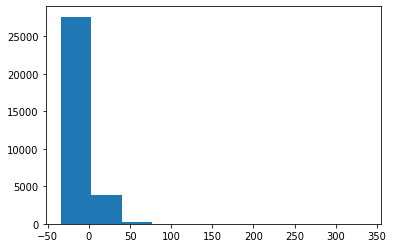

In [7]:
plt.hist(diff_tweetsToEngage["day_zero"])

(array([8199., 6486., 1837., 1544., 1642., 1690., 1801., 1966., 2809.,
        3704.]),
 array([-327. , -284.2, -241.4, -198.6, -155.8, -113. ,  -70.2,  -27.4,
          15.4,   58.2,  101. ]),
 <a list of 10 Patch objects>)

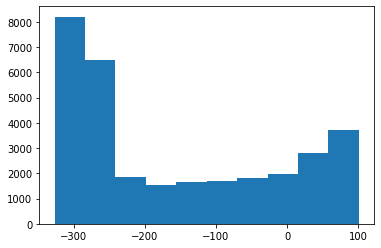

In [8]:
plt.hist(diff_tweetsToEngage["last_day"])

(array([1.3496e+04, 1.6708e+04, 9.4400e+02, 2.8100e+02, 1.0500e+02,
        7.6000e+01, 2.4000e+01, 2.7000e+01, 1.2000e+01, 5.0000e+00]),
 array([-327. , -285.4, -243.8, -202.2, -160.6, -119. ,  -77.4,  -35.8,
           5.8,   47.4,   89. ]),
 <a list of 10 Patch objects>)

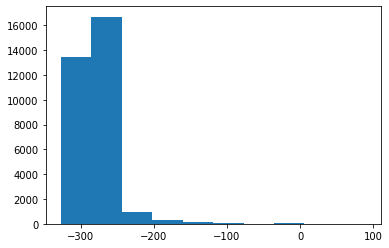

In [9]:
plt.hist(diff_tweetsToEngage["length"])

#### Problem
1. <s>tweets max 61 days, engage max ~400 days</s>
2. <s>diff_day_zero should not be negative</s> -> user at Youtube can modify publish date
3. In `date`.bz2 file, there can be tweets in both `date`-1 and `date`
4. tweets data are worse missing in last day and length

(array([0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 6.0000e+00, 2.2000e+01, 1.0649e+04,
        1.5464e+04, 9.3300e+02, 5.0800e+02, 3.5600e+02, 2.7600e+02,
        2.5600e+02, 2.3400e+02, 2.2000e+02, 3.6200e+02]),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9]),
 <a list of 19 Patch objects>)

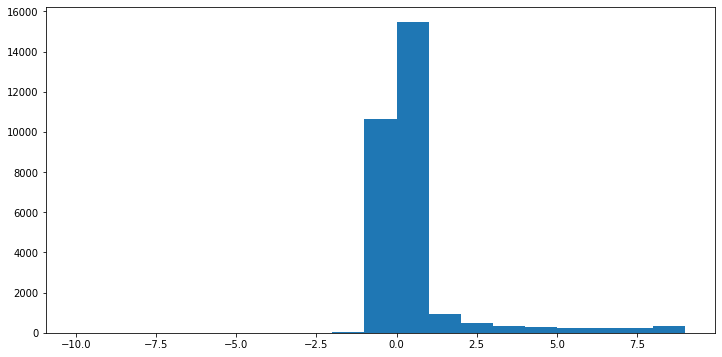

In [22]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

# ax.set_title(title, color="blue", fontsize=18)
# ax.legend(fontsize ="medium", ncol=3)
# ax.set_ylabel("neigh_dis_sum", color="blue", fontsize=16)
# ax.set_xlabel("dig_dis_sum", color="blue", fontsize=16)

ax.hist(diff_tweetsToEngage["day_zero"], bins=list(range(-10,10)))

In [18]:
from collections import Counter
Cnt = Counter(diff_tweetsToEngage["day_zero"])
Cnt

Counter({0: 15464,
         -34: 1,
         -4: 1,
         -2: 22,
         -1: 10649,
         1: 933,
         2: 508,
         3: 356,
         4: 276,
         5: 256,
         6: 234,
         -6: 2,
         7: 220,
         8: 180,
         -23: 1,
         9: 182,
         -3: 6,
         10: 144,
         11: 125,
         12: 140,
         13: 125,
         14: 108,
         15: 106,
         16: 97,
         17: 109,
         18: 91,
         19: 87,
         -9: 2,
         20: 96,
         21: 94,
         23: 71,
         22: 77,
         24: 64,
         25: 52,
         -8: 1,
         26: 52,
         27: 69,
         28: 50,
         30: 45,
         29: 55,
         31: 38,
         -7: 1,
         32: 52,
         33: 29,
         34: 39,
         35: 36,
         36: 31,
         37: 28,
         38: 31,
         40: 23,
         39: 22,
         41: 26,
         42: 30,
         43: 13,
         44: 11,
         45: 12,
         46: 14,
         48: 11,
        

In [21]:
for i in range(len(diff_tweetsToEngage["vids"])):
    vid = diff_tweetsToEngage["vids"][i]
    day_zero = diff_tweetsToEngage["day_zero"][i]
    if day_zero < 0:
        print(vid, day_zero)

3A4bITDU_LE -34
L6NLOEDag7w -4
95JKxXh6YiE -2
JJAE9vAK_Cc -1
XB0c3A4wQGA -1
8Abzf2juJV8 -1
rUvYQqf1NuQ -1
D77zlOWC08s -1
GQKGwdGHV5M -1
kvRJpAXQVhA -1
WR6n-rCOtf4 -1
7RX5J1fFsrI -1
zEqiboUNZRI -1
0gK_Zj2gIEs -1
ZTX5wtSK_1w -1
j00Tam7n0fs -1
UhHsmOJVuBI -1
YxPBAxD43Ww -1
JuHpcYLKU4g -1
ukwNJrUcd9A -1
XVCfXEILzM4 -1
GLTNd-_YoHE -1
fDrFLvtmD6M -1
dHnOz8xmUO0 -1
Fvwq4lPqYQg -1
0PEkwFnYofs -1
5_E-1HQXCww -1
oCc3BLZ3bIo -1
zHKLDtjFgxI -1
1TqTqo1xfu4 -1
beZDa9Yv9Tw -1
IpKiVHJE5nE -1
Y_Q7zVtl4yI -1
KGNH2ZIkSPI -1
KTodJ4yJXKg -1
qAXW4CktofY -1
TEPmNHtqfu0 -1
PnhgUPxLk0g -1
QE0gX0hhnFM -1
ghul0KW44qQ -1
eq90ACcNl4w -1
zLa2k2Au2pM -1
5QoJOsM3fsc -1
ezD-XE-bSNA -1
t_mHR0SW1uU -1
iFtxCHbhTwU -1
2Qo6hFKtJbI -1
XB1lspBzoEo -1
JonhsiEFbpU -1
9_qt7sr2tNc -1
cjWjgilDiHk -1
U6XxNVWFh1U -1
nHv0UrjZGh4 -1
bdNCH2RWYMY -1
1X6AxXZP2lw -1
7RVc-VQxRjU -1
2gvV-DM-YbI -1
-LuYX3w2p_Y -1
dBN5yHSIoJs -1
TtOEcesVAdA -1
FsvXjMGAW4c -1
THwOnDl_dHI -1
h5j9r518l58 -1
hQsOy43dW-8 -1
ixopcOLUX68 -1
YR_GE72xlXQ -1
xIGSagSxI

sNEZojjPPXM -1
-zEOhDqRnG4 -1
oEGoD7bTnSo -1
BoW5laCP9_g -1
PjmPTTWWEmM -1
NLcoO69MWss -1
izSjKreNlyo -1
eactyCuhP3E -1
nltG4PeWbI4 -1
-eT90Euo_zs -1
JKqokA52srs -1
B1CCbixnS6M -1
GbLe69fSWFk -1
ITfsOvCwiaM -1
BR8N-5RM-aM -1
dI7IYZTkhYA -1
HhqC2bOS92w -1
T_kuRRvL_5M -1
Y7VQaBvdGas -1
SLsWe-VOnPM -1
UT3ZpZ7sq_c -1
r3zNlok4BWo -1
_9IkzBGoM6s -1
jz8X8wzAZVw -1
ge7n2aaTEPo -1
6r1b3ooTU20 -1
eF4yUPpbHCk -1
ko-2XDLAcw0 -1
CROknS4dX7Q -1
HH_XZ5ca0sg -1
-ev1cRpknWM -1
D9x-vLjj-jU -1
pN9ZhVw0abs -1
wRjKihXhnC8 -1
xUF29XmqfXQ -1
Icsw_ZMt8cM -1
qfMDJxxVmd8 -1
yqIhq9B4YH0 -1
QFnDDWn5uic -1
r9z5gINSV_I -1
Typ8jMB4hu0 -1
_FyQfNVGU-o -1
8FG1XDjV2oI -1
dHbNzs2TXO4 -1
C7FWO-KlL1w -1
pkw_uQAOmC4 -1
r2a5pRCBKVk -1
bqswN3jscwo -1
TFtWUuuEeKk -1
WlFc7lWHSno -1
FKNbnDfsZlk -1
M86k77J190c -1
RuDnLQaSlZg -1
BzXiTqoLF5Q -1
4eQz709SibI -1
BSpybypgWco -1
BbEYCo6uxDg -1
9_mooWyxIno -1
kdmbaVxiMN0 -1
LE2SP0znt0w -1
F4HZ6CD_zkM -1
2wGZqrkcoWQ -1
xI-NT33adpI -1
iY-gKs3AhWU -1
lLNoAuZL04k -1
0XQD2pgbHKk -1
3Qo9h9d-Nj

KeyboardInterrupt: 

In [23]:
num = 0
for i in range(len(diff_tweetsToEngage["vids"])):
    vid = diff_tweetsToEngage["vids"][i]
    day_zero = diff_tweetsToEngage["last_day"][i]
    if day_zero < -300:
        num += 1
        if num>=10: break
        print(vid, day_zero)

NpjBsjecA9g -322
PxD_KEuDCHo -321
2UHIuEABkwU -319
2QYMTmEPcOc -307
FXe4XlkclQs -315
KMruufNRDvY -315
0Yg8HPwufBw -312
ZNV-mSx0aAc -310
V-XFDH2Ijj4 -303


In [24]:
tweets_dataset['NpjBsjecA9g']

{'day_zero': '2016-07-01', 'days': [0], 'tweets': [1]}

In [25]:
engage_dataset['NpjBsjecA9g']

('2016-07-01',
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  86,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  117,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
 